In [1]:
#importing necessary libraries
import comet_ml
from comet_ml.integration.pytorch import watch

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "downsampled_clips/emotion_dataset.csv"
data = pd.read_csv(DATA_PATH)
data.head()

,emotion,path
0,surprise,dataset/audio_speech_actors_01-24/Actor_24/03-...
1,fear,dataset/audio_speech_actors_01-24/Actor_24/03-...
2,angry,dataset/audio_speech_actors_01-24/Actor_24/03-...
3,surprise,dataset/audio_speech_actors_01-24/Actor_24/03-...
4,fear,dataset/audio_speech_actors_01-24/Actor_24/03-...


In [3]:
unique_emotions = data.emotion.unique()
EMOTIONS = {i: emotion for i, emotion in enumerate(unique_emotions)}
EMOTIONS = {v: k for k, v in EMOTIONS.items()}
EMOTIONS

{'surprise': 0,
 'fear': 1,
 'angry': 2,
 'neutral': 3,
 'sad': 4,
 'disgust': 5,
 'happy': 6}

In [4]:
data["emotion"].head()

0    surprise
1        fear
2       angry
3    surprise
4        fear
Name: emotion, dtype: object

In [5]:
data['emotion'] = data['emotion'].str.strip().str.lower()
data['emotion'] = data["emotion"].map(EMOTIONS)

In [6]:
print(f"number of data:{len(data)}")
data.head()

number of data:12102


,emotion,path
0,0,dataset/audio_speech_actors_01-24/Actor_24/03-...
1,1,dataset/audio_speech_actors_01-24/Actor_24/03-...
2,2,dataset/audio_speech_actors_01-24/Actor_24/03-...
3,0,dataset/audio_speech_actors_01-24/Actor_24/03-...
4,1,dataset/audio_speech_actors_01-24/Actor_24/03-...


In [7]:
mel_spectrograms = []
signals = [] 
SAMPLE_RATE = 48000


for i, file_path in enumerate(data.path):
    # Load the audio file with librosa; load 3 seconds of audio starting from 0.5 seconds
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    
    # Create an empty signal of length 3 seconds (SAMPLE_RATE * 3) filled with zeros
    signal = np.zeros((int(SAMPLE_RATE * 3,)))
    
    signal[:len(audio)] = audio
    
    signals.append(signal)
    
    print("\rProcessed {}/{} files".format(i + 1, len(data)), end='')

signals = np.stack(signals, axis=0)

Processed 12102/12102 files

In [8]:
X = signals  # Assign the processed signals to X for simplicity

train_ind, test_ind, val_ind = [], [], [] 
X_train, X_val, X_test = [], [], [] 
Y_train, Y_val, Y_test = [], [], []  

# Loop over each emotion category (based on the EMOTIONS dictionary)
for emotion in range(len(EMOTIONS)):
    # Get indices of all samples belonging to the current emotion
    emotion_ind = list(data.loc[data.emotion == emotion, 'emotion'].index)
    
    # Shuffle the indices randomly
    emotion_ind = np.random.permutation(emotion_ind)

    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8 * m)]
    ind_val = emotion_ind[int(0.8 * m):int(0.9 * m)]
    ind_test = emotion_ind[int(0.9 * m):]

    X_train.append(X[ind_train, :])
    Y_train.append(np.array([emotion] * len(ind_train), dtype=np.int32)) 
    
    X_val.append(X[ind_val, :])
    Y_val.append(np.array([emotion] * len(ind_val), dtype=np.int32))
    
    X_test.append(X[ind_test, :])
    Y_test.append(np.array([emotion] * len(ind_test), dtype=np.int32))
    
    # Store the indices used for train, validation, and test sets
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)

X_train = np.concatenate(X_train, 0)
X_val = np.concatenate(X_val, 0)
X_test = np.concatenate(X_test, 0)
Y_train = np.concatenate(Y_train, 0)
Y_val = np.concatenate(Y_val, 0)
Y_test = np.concatenate(Y_test, 0)

train_ind = np.concatenate(train_ind, 0)
val_ind = np.concatenate(val_ind, 0)
test_ind = np.concatenate(test_ind, 0)

# Print the shapes of the training, validation, and test sets for both data (X) and labels (Y)
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')

# Check if all indices are unique (i.e., there are no overlaps between train, validation, and test sets)
unique, count = np.unique(np.concatenate([train_ind, test_ind, val_ind], 0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count == 1), X.shape[0]))

# Delete the original signals array to free up memory
del X

X_train: (9679, 144000), Y_train: (9679,)
X_val: (1208, 144000), Y_val: (1208,)
X_test: (1215, 144000), Y_test: (1215,)
Number of unique indexes is 12102, out of 12102


In [9]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    
    signal_len = len(signal)  # Length of the input signal
    noise = np.random.normal(size=(augmented_num, signal_len))

    norm_constant = 2.0 ** (num_bits - 1)
    signal_norm = signal / norm_constant 
    noise_norm = noise / norm_constant    
    
    s_power = np.sum(signal_norm ** 2) / signal_len
    
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    
    target_snr = np.random.randint(snr_low, snr_high)
    
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    
    K = np.ones((signal_len, augmented_num)) * K
    
    return signal + K.T * noise



In [11]:
aug_signals = []  # List to store the augmented signals
aug_labels = []   # List to store the corresponding labels for the augmented signals

# Loop through each sample in the training set
for i in range(X_train.shape[0]):
    signal = X_train[i, :]  # Extract the i-th signal from X_train
    
    # Generate augmented signals by adding Additive White Gaussian Noise (AWGN) to the original signal
    augmented_signals = addAWGN(signal)
    
    # Loop through each of the generated augmented signals
    for j in range(augmented_signals.shape[0]):
        # Append the emotion label of the current sample to the augmented labels
        aug_labels.append(data.loc[i, "emotion"])
        
        # Append the j-th augmented signal to the list of augmented signals
        aug_signals.append(augmented_signals[j, :])
        
        # Create a temporary DataFrame for the current data row
        temp_df = pd.DataFrame(data.iloc[i]).T
        
        # Concatenate the current row to the original DataFrame using pd.concat
        data = pd.concat([data, temp_df], ignore_index=True)
    
    # Print the progress of the augmentation process
    print("\rProcessed {}/{} files".format(i, X_train.shape[0]), end='')

# Convert the list of augmented signals into a NumPy array for easier concatenation
aug_signals = np.stack(aug_signals, axis=0)

# Concatenate the original training signals with the augmented signals
X_train = np.concatenate([X_train, aug_signals], axis=0)

# Convert the list of augmented labels into a NumPy array
aug_labels = np.stack(aug_labels, axis=0)

# Concatenate the original training labels with the augmented labels
Y_train = np.concatenate([Y_train, aug_labels])

# Print final shapes of the augmented training data and labels
print('')
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')


Processed 91/9679 files

Processed 9678/9679 files
X_train: (29037, 144000), Y_train: (29037,)


MEL spectrogram shape:  (128, 563)


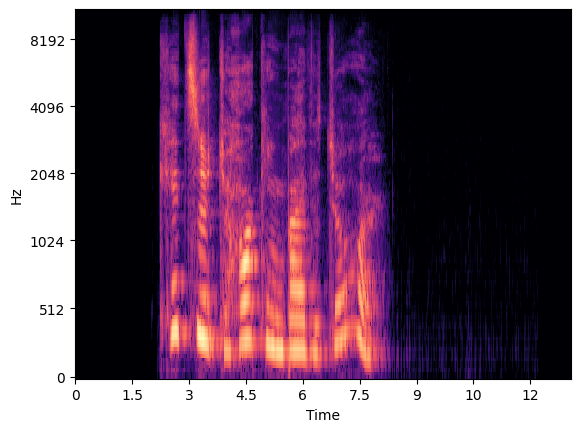

In [13]:
def getMELspectrogram(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio,sr=sample_rate,n_fft=1024,win_length=512,window='hamming',hop_length=256,n_mels=128,fmax=sample_rate/2)
    # Convert power spectrogram to decibel scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

audio, sample_rate = librosa.load(data.loc[0,'path'], duration=3, offset=0.5, sr=SAMPLE_RATE)
# Create an empty signal array of length equal to 3 seconds
signal = np.zeros((int(SAMPLE_RATE*3,)))

# Fill the signal array with the audio data
signal[:len(audio)] = audio

mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)

librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')

print('MEL spectrogram shape: ',mel_spectrogram.shape)


In [14]:
# List to store the MEL spectrograms for the training set
mel_train = []
print("Calculating MEL spectrograms for train set")

for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i, :], sample_rate=SAMPLE_RATE)
    
    mel_train.append(mel_spectrogram)
 
    print("\rProcessed {}/{} files".format(i, X_train.shape[0]), end='')

print('') 
del X_train  

mel_val = []
print("Calculating MEL spectrograms for validation set")

for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i, :], sample_rate=SAMPLE_RATE)

    mel_val.append(mel_spectrogram)

    print("\rProcessed {}/{} files".format(i, X_val.shape[0]), end='')

print('') 
del X_val 

mel_test = []
print("Calculating MEL spectrograms for test set")

for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i, :], sample_rate=SAMPLE_RATE)
    
    mel_test.append(mel_spectrogram)

    print("\rProcessed {}/{} files".format(i, X_test.shape[0]), end='')

print('') 
del X_test 


Calculating MEL spectrograms for train set
Processed 20/29037 files

Processed 29036/29037 files
Calculating MEL spectrograms for validation set
Processed 1207/1208 files
Calculating MEL spectrograms for test set
Processed 1214/1215 files


In [15]:
def splitIntoChunks(mel_spec, win_size, stride):
    t = mel_spec.shape[1]
    
    num_of_chunks = int(t / stride)

    chunks = []

    for i in range(num_of_chunks):
        chunk = mel_spec[:, i * stride:i * stride + win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)

    return np.stack(chunks, axis=0)


In [16]:
mel_train_chunked = []

for mel_spec in mel_train:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_train_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))
mel_val_chunked = []


for mel_spec in mel_val:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_val_chunked.append(chunks)

print("Number of chunks is {}".format(chunks.shape[0]))

mel_test_chunked = []


for mel_spec in mel_test:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_test_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))


Number of chunks is 7
Number of chunks is 7
Number of chunks is 7


In [17]:

#creating a model

import torch
import torch.nn as nn

# TimeDistributed layer for applying a module to each time step in a sequence
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        if len(x.size()) == 3:
            x_reshape = x.contiguous().view(-1, x.size(2)) 
        elif len(x.size()) == 4: 
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3))
        else: 
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3), x.size(4))
        
        # Apply the module to the reshaped tensor
        y = self.module(x_reshape)
        
        
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1)) 
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2))  
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2), y.size(3))  
        return y



In [18]:
import torch
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, num_emotions):
        """
        Initialize the HybridModel with convolutional, LSTM, and attention layers.

        Parameters:
        - num_emotions: Number of emotion classes for classification.
        """
        super().__init__()

        # Convolutional Block
        self.conv2Dblock = nn.Sequential(
            # 1. Convolutional Block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1)),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.3)),
            # 2. Convolutional Block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1)),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3)),
            # 3. Convolutional Block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1)),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3))
        )
        
        # LSTM Block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=1024, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.4)
        self.attention_linear = nn.Linear(2 * hidden_size, 1)  # 2 * hidden_size for bidirectional LSTM
        
        # Linear layer for output classification
        self.out_linear = nn.Linear(2 * hidden_size, num_emotions)
    
    def forward(self, x):  
        conv_embedding = self.conv2Dblock(x)
        
        conv_embedding = torch.flatten(conv_embedding, start_dim=2)
        
        # Apply LSTM layers
        lstm_embedding, (h, c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        
        # Compute attention weights
        batch_size, T, _ = lstm_embedding.shape
        attention_weights = [None] * T
        for t in range(T):
            embedding = lstm_embedding[:, t, :]
            attention_weights[t] = self.attention_linear(embedding)
        
        # Normalize attention weights
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights, -1), dim=-1)
        
        # Apply attention to LSTM outputs
        attention = torch.bmm(attention_weights_norm, lstm_embedding)  # (Bx1xT)*(B,T,hidden_size*2) = (B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        
        # Compute output logits and softmax probabilities
        output_logits = self.out_linear(attention)
        output_softmax = nn.functional.softmax(output_logits, dim=1)
        
        return output_logits, output_softmax, attention_weights_norm
    
    
def loss_fnc(predictions, targets):

    loss_function = nn.CrossEntropyLoss()

    return loss_function(input=predictions, target=targets)



In [ ]:
from dotenv import load_dotenv
load_dotenv()

# Fetch API key and project name from environment variables
comet_api_key = os.getenv('API_KEY')
project_name = os.getenv('PROJECT_NAME')

# Initialize Comet experiment using the fetched environment variables
experiment = comet_ml.Experiment(
    api_key=comet_api_key,
    project_name=project_name
)

In [29]:
# True labels for confusion matrix logging
emotion_labels = {0: 'surprise', 1: 'fear', 2: 'angry', 3: 'neutral', 4: 'sad', 5: 'disgust', 6: 'happy'}

In [19]:
#training process
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        model.train()
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions) / float(len(Y))
        loss = loss_fnc(output_logits, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy * 100
    return train_step  


In [30]:
def make_validate_fnc(model, loss_fnc):
    def validate(X, Y):
        # Disable gradient calculations for validation to save memory and computation
        with torch.inference_mode():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax, dim=1)
            accuracy = torch.sum(Y == predictions) / float(len(Y))

            # Log the confusion matrix to Comet
            experiment.log_confusion_matrix(
                y_true=Y,
                y_predicted=predictions,
                labels=list(emotion_labels.values())  # Use the labels defined earlier
            )

            loss = loss_fnc(output_logits, Y)
            
        return loss.item(), accuracy * 100, predictions
    
    return validate  # Return t

In [21]:
# Convert the list of chunked mel spectrograms for training, validation, and test sets into numpy arrays
X_train = np.stack(mel_train_chunked, axis=0)  
X_train = np.expand_dims(X_train, 2) 
print('Shape of X_train: ', X_train.shape)

X_val = np.stack(mel_val_chunked, axis=0) 
X_val = np.expand_dims(X_val, 2) 
print('Shape of X_val: ', X_val.shape)

X_test = np.stack(mel_test_chunked, axis=0)
X_test = np.expand_dims(X_test, 2)  
print('Shape of X_test: ', X_test.shape)


del mel_train_chunked
del mel_train
del mel_val_chunked
del mel_val
del mel_test_chunked
del mel_test


Shape of X_train:  (29037, 7, 1, 128, 128)
Shape of X_val:  (1208, 7, 1, 128, 128)
Shape of X_test:  (1215, 7, 1, 128, 128)


scaling the data

In [22]:
import joblib
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Reshape X_train, scale it, and reshape back
b, t, c, h, w = X_train.shape
X_train = np.reshape(X_train, newshape=(b, -1))  # Flatten each sample
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_train = np.reshape(X_train, newshape=(b, t, c, h, w))  # Reshape back to original form

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

b, t, c, h, w = X_test.shape
X_test = np.reshape(X_test, newshape=(b, -1)) 
X_test = scaler.transform(X_test)  
X_test = np.reshape(X_test, newshape=(b, t, c, h, w)) 

b, t, c, h, w = X_val.shape
X_val = np.reshape(X_val, newshape=(b, -1))
X_val = scaler.transform(X_val)  
X_val = np.reshape(X_val, newshape=(b, t, c, h, w))  

In [31]:
EPOCHS=300
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Selected device is {}'.format(device))
model = HybridModel(num_emotions=len(EMOTIONS)).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()))  
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)  # Define the optimizer

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER) 
validate = make_validate_fnc(model, loss_fnc) 
losses = []  
val_losses = [] 

for epoch in range(EPOCHS):
    # Shuffle data at the start of each epoch
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind, :, :, :, :]
    Y_train = Y_train[ind]

    epoch_acc = 0  
    epoch_loss = 0  
    iters = int(DATASET_SIZE / BATCH_SIZE)  # Number of iterations per epoch

    # Iterate over batches
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end - batch_start

        X = X_train[batch_start:batch_end, :, :, :, :]
        Y = Y_train[batch_start:batch_end]

        # Move data to the appropriate device
        X_tensor = torch.tensor(X, device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)

        #training step
        loss, acc = train_step(X_tensor, Y_tensor)
        epoch_acc += acc * actual_batch_size / DATASET_SIZE
        epoch_loss += loss * actual_batch_size / DATASET_SIZE 

        # Log metrics for this step
        experiment.log_metric("train_loss", epoch_loss, step=epoch)
        experiment.log_metric("train_accuracy", epoch_acc, step=epoch)

        print(f"\r Epoch {epoch}: iteration {i}/{iters}", end='')  # Display training progress

    # Validation after each epoch
    X_val_tensor = torch.tensor(X_val, device=device).float()
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.long, device=device)
    val_loss, val_acc, _ = validate(X_val_tensor, Y_val_tensor)

    # Log metrics for this step
    experiment.log_metric("val_loss", val_loss, step=epoch)
    experiment.log_metric("val_accuracy", val_acc, step=epoch)

    losses.append(epoch_loss) 
    val_losses.append(val_loss)  

    # Print summary of the epoch
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")

Selected device is cuda
Number of trainable params:  582632


 Epoch 0: iteration 906/907
Epoch 0 --> loss:1.8762, acc:18.88%, val_loss:1.8391, val_acc:19.21%
 Epoch 1: iteration 906/907
Epoch 1 --> loss:1.8327, acc:21.54%, val_loss:1.7097, val_acc:29.22%
 Epoch 2: iteration 906/907
Epoch 2 --> loss:1.7923, acc:23.85%, val_loss:1.6652, val_acc:30.38%
 Epoch 3: iteration 906/907
Epoch 3 --> loss:1.7645, acc:25.33%, val_loss:1.4894, val_acc:40.73%
 Epoch 4: iteration 906/907
Epoch 4 --> loss:1.7453, acc:26.24%, val_loss:1.4596, val_acc:42.38%
 Epoch 5: iteration 906/907
Epoch 5 --> loss:1.7280, acc:27.02%, val_loss:1.3582, val_acc:46.44%
 Epoch 6: iteration 906/907
Epoch 6 --> loss:1.7120, acc:27.85%, val_loss:1.3230, val_acc:47.85%
 Epoch 7: iteration 906/907
Epoch 7 --> loss:1.7020, acc:28.28%, val_loss:1.3092, val_acc:50.00%
 Epoch 8: iteration 906/907
Epoch 8 --> loss:1.6888, acc:28.93%, val_loss:1.2590, val_acc:52.40%
 Epoch 9: iteration 906/907
Epoch 9 --> loss:1.6790, acc:29.14%, val_loss:1.2538, val_acc:54.39%


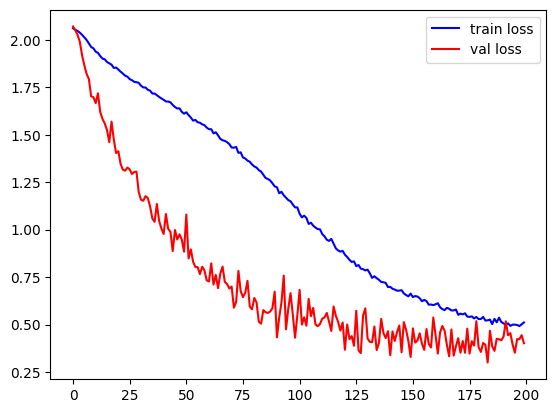

In [ ]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])

In [ ]:
#saving the model
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'speech_sentiment_asr.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'speech_sentiment_asr.pt')))

Model is saved to /kaggle/working/models/speech_sentiment_asr.pt


In [ ]:
#loading and testing
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'speech_sentiment_asr.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'speech_sentiment_asr.pt')))

Model is loaded from /kaggle/working/models/speech_sentiment_asr.pt


/tmp/ipykernel_35/1887058462.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'speech_sentiment_asr.pt')))


In [ ]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.445
Test accuracy is 84.64%


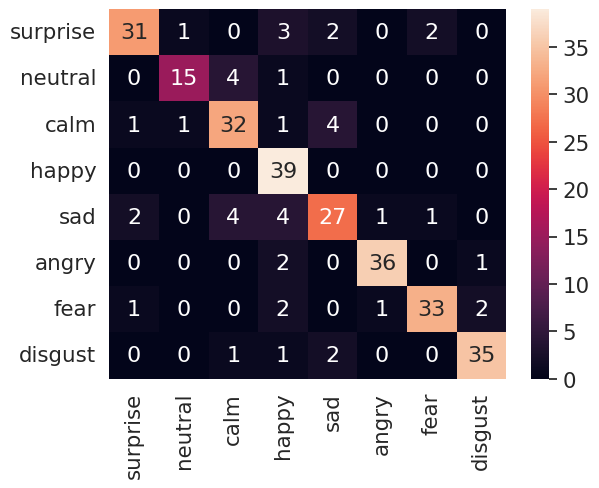

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()


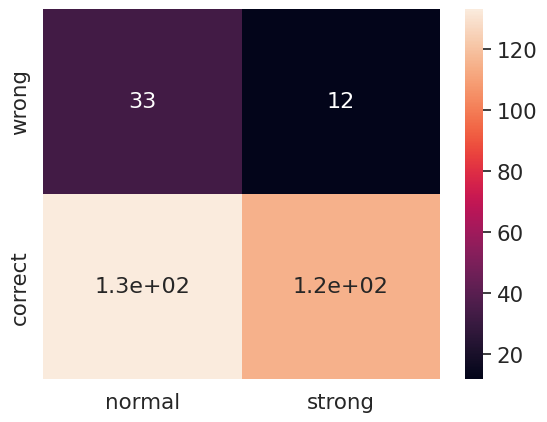

In [ ]:
#Correlation between emotion intensity and correct prediction
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

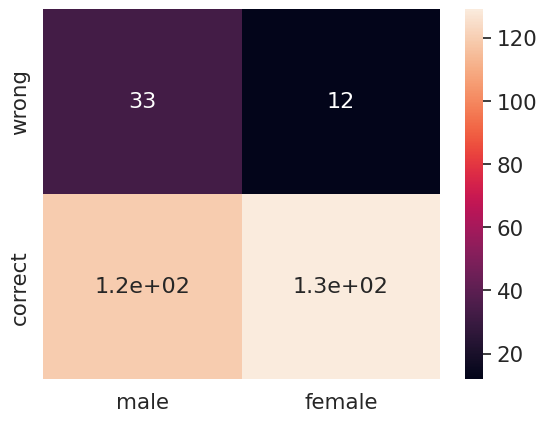

In [ ]:
#correlation between gender and corectness
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()